In [48]:
from sklearn.ensemble import RandomForestClassifier
from Preprocess import Preprocessor, new_OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, RFECV, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgbm
plt.rcParams.update({'text.color' : "w",
                     'axes.labelcolor' : "w",
                     'xtick.color' : "w",
                     'ytick.color' : "w"})

In [49]:
data = pd.read_csv('titanic.csv')
train,_ = train_test_split(data,test_size=0.2,random_state=42)
train['Relative'] = train['SibSp'] + train['Parch']
train.reset_index(inplace=True,drop=True)
train
results = []

<ipython-input-49-44b1720866fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Relative'] = train['SibSp'] + train['Parch']


In [50]:
train.loc[:,'Sex'] = (train['Sex']=='male').astype(int)
train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split()[0])
train['No_Age'] = train['Age'].isna().astype(int)
train['No_Cabin'] = train['Cabin'].isna().astype(int)
splitted_cabin = train['Cabin'].dropna().str.split(pat='[\d ]').apply(lambda x: x[0])
train['Cabin_Deck'] = pd.DataFrame(splitted_cabin.tolist(), index = splitted_cabin.index)
train.drop(['Cabin','Name','Ticket'],axis=1,inplace=True)
train.isna().sum(axis=0)
# train,train_cv = train_test_split(train,test_size=0.2,random_state=42)

c:\users\ariel\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-50-5e932b777ebd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split()[0])
<ipython-input-50-5e932b777ebd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Survived        0
Pclass          0
Sex             0
Age           138
SibSp           0
Parch           0
Fare            0
Embarked        2
Relative        0
Title           0
No_Age          0
No_Cabin        0
Cabin_Deck    550
dtype: int64

In [51]:
print(train.shape)
# train.select_dtypes(exclude=object)
train.dtypes

(712, 13)


Survived        int64
Pclass          int64
Sex             int32
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked       object
Relative        int64
Title          object
No_Age          int32
No_Cabin        int32
Cabin_Deck     object
dtype: object

In [52]:
train.dtypes

Survived        int64
Pclass          int64
Sex             int32
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked       object
Relative        int64
Title          object
No_Age          int32
No_Cabin        int32
Cabin_Deck     object
dtype: object

In [53]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=4, weights="uniform")
age_imp = imputer.fit_transform(train.iloc[:,1:].select_dtypes(exclude=object))[:,2]
# age_imp_cv = imputer.transform(train_cv.iloc[:,1:].select_dtypes(exclude=object))[:,2]
train['age_imp'] = age_imp
# train_cv['age_imp'] = age_imp_cv
age_mean = train.groupby('Title')['Age'].mean()
ages = train.apply(lambda x : age_mean[x['Title']] if np.isnan(x['Age']) else x['Age'],axis=1)
# ages_cv = train_cv.apply(lambda x : age_mean[x['Title']] if np.isnan(x['Age']) else x['Age'],axis=1)
train['age_title'] = ages
# train_cv['age_title'] = ages_cv
naive_mean = train['Age'].mean()
train['age_naive_imp'] = train['Age'].fillna(value=naive_mean)
# train_cv['age_naive_imp'] = train['Age'].fillna(value=naive_mean)
# train[['Age','age_imp','ages_by_title']][train['Age'].isna()]

<ipython-input-53-3ccc3bf2c345>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['age_imp'] = age_imp
<ipython-input-53-3ccc3bf2c345>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['age_title'] = ages
<ipython-input-53-3ccc3bf2c345>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [54]:
train.drop('Age',axis=1,inplace=True)
# train_cv.drop('Age',axis=1,inplace=True)

c:\users\ariel\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [55]:
print(train.dtypes)

Survived           int64
Pclass             int64
Sex                int32
SibSp              int64
Parch              int64
Fare             float64
Embarked          object
Relative           int64
Title             object
No_Age             int32
No_Cabin           int32
Cabin_Deck        object
age_imp          float64
age_title        float64
age_naive_imp    float64
dtype: object


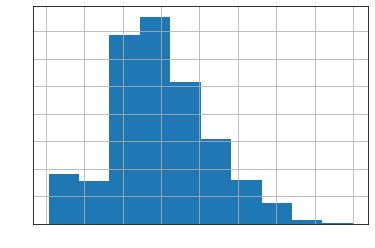

In [56]:
train['age_imp'].hist()
# train_cv['age_imp'].hist()

In [57]:
train

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Relative,Title,No_Age,No_Cabin,Cabin_Deck,age_imp,age_title,age_naive_imp
0,1,1,0,0,0,151.5500,S,0,Miss.,0,1,NaN,22.0,22.000000,22.000000
1,0,2,1,0,0,12.2750,S,0,Mr.,0,1,NaN,33.0,33.000000,33.000000
2,1,3,0,0,2,15.7417,C,2,Miss.,0,1,NaN,1.0,1.000000,1.000000
3,0,3,0,8,2,69.5500,S,10,Miss.,1,1,NaN,32.0,22.151786,29.514808
4,0,2,1,0,0,10.5000,S,0,Mr.,0,1,NaN,70.0,70.000000,70.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,1,3,0,0,0,7.6500,S,0,Miss.,0,1,NaN,21.0,21.000000,21.000000
708,0,1,1,0,0,31.0000,S,0,Mr.,1,1,NaN,36.0,32.024465,29.514808
709,0,3,1,2,0,14.1083,S,2,Mr.,0,1,NaN,41.0,41.000000,41.000000
710,1,1,0,1,2,120.0000,S,3,Miss.,0,0,B,14.0,14.000000,14.000000


In [58]:
# for bin_size in range(5,15,2):
# bin_imp = 'bin_imp_' + str(bin_size)
# bin_title = 'bin_title_' + str(bin_size)
disc = KBinsDiscretizer(encode='ordinal',n_bins=5)

disc_groups = disc.fit_transform(train[['age_imp','age_title','Fare']])
# disc_groups.shape
train['bin_imp'] = disc_groups[:,0]
train['bin_title'] = disc_groups[:,1]
train['bin_fare'] = disc_groups[:,2]
train[['bin_imp','age_imp','bin_title','age_title','bin_fare']]

<ipython-input-58-f95286a7d163>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['bin_imp'] = disc_groups[:,0]
<ipython-input-58-f95286a7d163>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['bin_title'] = disc_groups[:,1]
<ipython-input-58-f95286a7d163>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

,bin_imp,age_imp,bin_title,age_title,bin_fare
0,1.0,22.0,1.0,22.000000,4.0
1,3.0,33.0,3.0,33.000000,2.0
2,0.0,1.0,0.0,1.000000,2.0
3,3.0,32.0,1.0,22.151786,4.0
4,4.0,70.0,4.0,70.000000,1.0
...,...,...,...,...,...
707,1.0,21.0,1.0,21.000000,0.0
708,3.0,36.0,3.0,32.024465,3.0
709,4.0,41.0,4.0,41.000000,2.0
710,0.0,14.0,0.0,14.000000,4.0


In [59]:
# plt.figure(figsize=(22,20))
# train[train['Fare']<400]['Fare'].hist(bins=10)
# train[['bin_imp','age_imp','bin_title','age_title','Fare','bin_fare']].hist()


In [60]:
text_cat = ['Embarked','Title','Cabin_Deck']
# train.dtypes
enc = new_OrdinalEncoder()
train[text_cat] = enc.fit_transform(train[text_cat].astype(str))

c:\users\ariel\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [61]:
train.dtypes

Survived           int64
Pclass             int64
Sex                int32
SibSp              int64
Parch              int64
Fare             float64
Embarked           int64
Relative           int64
Title              int64
No_Age             int32
No_Cabin           int32
Cabin_Deck         int64
age_imp          float64
age_title        float64
age_naive_imp    float64
bin_imp          float64
bin_title        float64
bin_fare         float64
dtype: object

In [62]:
def cross_val_score_that_isnt_crap(est,X,y):
    kf = KFold(shuffle=True)
    scores = np.zeros(5)
    for i,(train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        e = est
        e.fit(X_train,y_train)
        scores[i] = roc_auc_score(y_test,e.predict(X_test))
    return scores.mean()

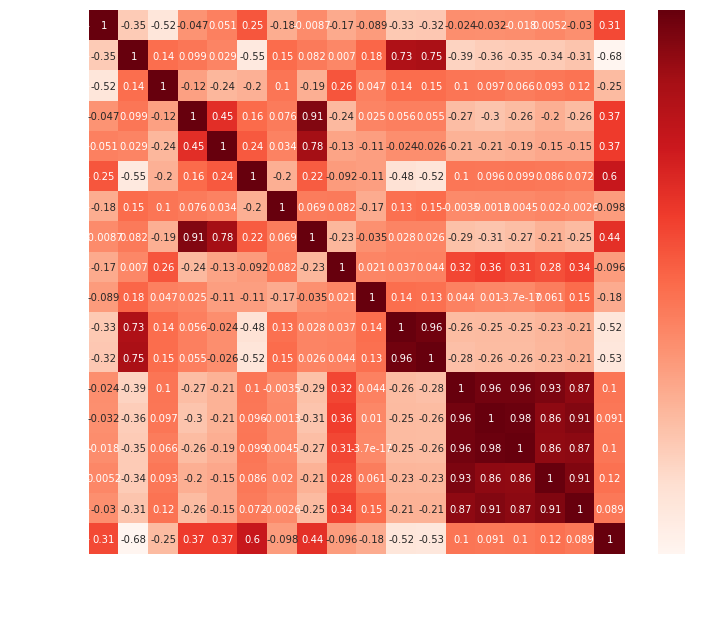

In [63]:
#Using Pearson Correlation - since values are 0/1
plt.figure(figsize=(12,10))
cor = train.corr() # wrong. correlation isn't relevant for categories!
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [64]:
poly = PolynomialFeatures(2)
numeric_col = ['age_imp','Fare','Parch','SibSp']
poly_features = pd.DataFrame(poly.fit_transform(train[numeric_col]),columns=poly.get_feature_names(numeric_col))
train = pd.concat([train.drop(numeric_col,axis=1),poly_features],axis=1)

In [65]:
train.shape

(712, 29)

Text(0.5, 1.0, 'histogram of deck levels')

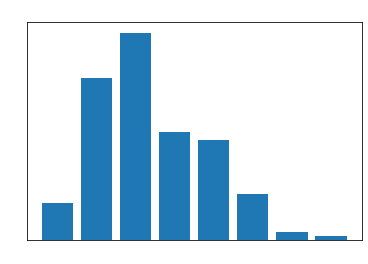

In [66]:
decks = train['Cabin_Deck'][train['Cabin_Deck']<8].value_counts()
plt.bar(decks.index,decks)
plt.title('histogram of deck levels')

In [67]:
for i in range(2,8):
    feat_name = 'Cabin_Deck_' + str(i) + '_Deep'
    # train[]

<Figure size 576x432 with 0 Axes>

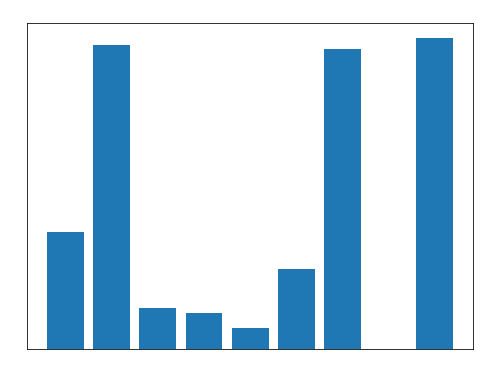

          cat chi_scores
0      Pclass    25.6444
1         Sex    66.9392
2    Embarked    8.96596
3       Title    7.91928
4      No_Age    4.54144
5    No_Cabin    17.6687
6  Cabin_Deck     66.024
7     bin_imp   0.019162
8    bin_fare    68.3515
selected: 
       columns   scores
0      Pclass  25.6444
1         Sex  66.9392
2    Embarked  8.96596
3    No_Cabin  17.6687
4  Cabin_Deck   66.024
5    bin_fare  68.3515


In [68]:
# 'Survived','dummy',
plt.figure(figsize=(8,6))
cat_features = ['Pclass','Sex','Embarked','Title','No_Age','No_Cabin','Cabin_Deck','bin_imp','bin_fare']
cf = pd.Series(cat_features)
# train['dummy'] = 1
# train[cat_features]
y = train['Survived']
# kb = SelectKBest(chi2,k=5)
# best = kb.fit_transform(train[cat_features], y)
# chi_scores = kb.scores_
# plt.bar(cat_features,kb.scores_)
# plt.title('category scores from chi2')
# plt.show()
def selectKBest_and_plot(X,cols,y,k=6,v=True):
    kb = SelectKBest(chi2,k=k)
    best_cat = pd.DataFrame(kb.fit_transform(X[cols], y),columns=cols[kb.get_support()])
    if(v):
        plt.figure(figsize=(8,6))
        plt.bar(cols,kb.scores_)
        plt.title('category scores from Chi2')
        plt.show()
        print(pd.DataFrame(np.c_[cols,kb.scores_],columns=['cat','chi_scores']))
        print('selected: \n',pd.DataFrame(np.c_[cols,kb.scores_][kb.get_support()],columns=['columns','scores']))
    return best_cat
best_cat = selectKBest_and_plot(train,cf,y)

[False False False False False False  True  True  True False  True False
 False  True  True False False  True  True] 
 [9.85782264e-12 1.74903596e-01 2.06774033e-01 4.33205045e-10
 1.40898981e-04 1.12951499e-01 2.05039839e-02 7.96620888e-03]


c:\users\ariel\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
c:\users\ariel\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


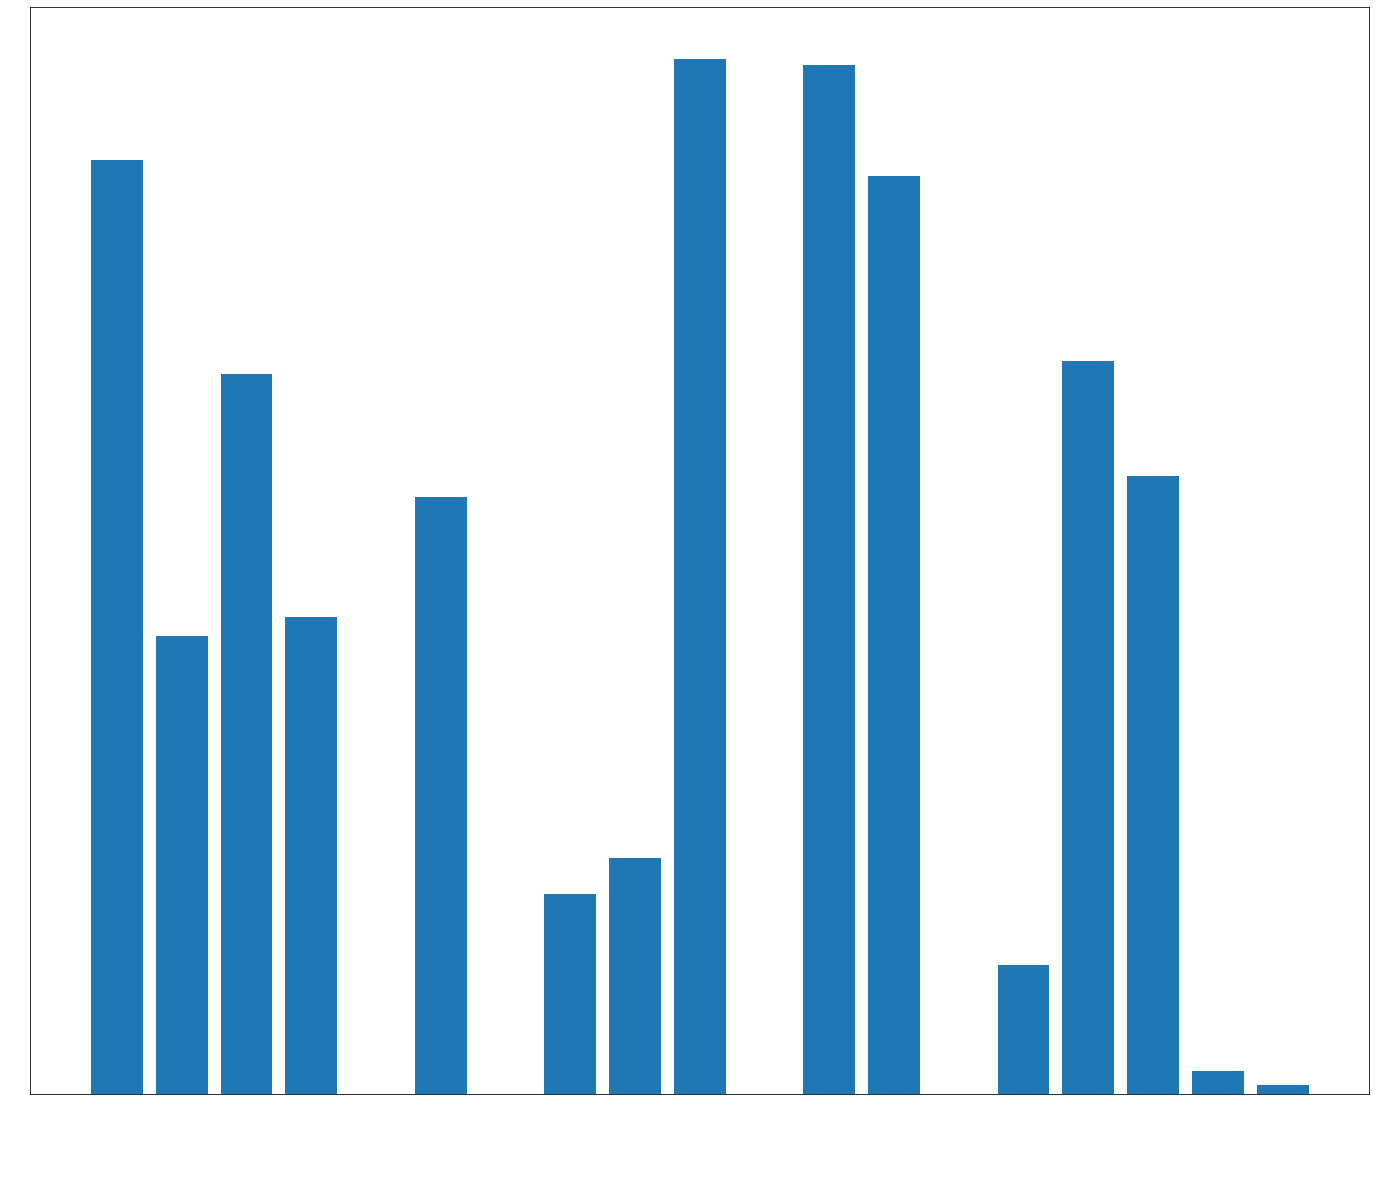

In [69]:
plt.figure(figsize=(24,20))
numeric_df = train.drop(cat_features+['Survived'],axis=1)
kb_numeric = SelectKBest(f_classif,k=8)
best_numeric = pd.DataFrame(kb_numeric.fit_transform(numeric_df,y),columns=numeric_df.columns[kb_numeric.get_support()])
plt.bar(numeric_df.columns,kb_numeric.pvalues_)
plt.xticks(rotation='vertical')
print(kb_numeric.get_support(),'\n',kb_numeric.pvalues_[kb_numeric.get_support()])

In [70]:
# kb_numeric.pvalues_
# best_numeric
best_cat

,Pclass,Sex,Embarked,No_Cabin,Cabin_Deck,bin_fare
0,1.0,0.0,2.0,1.0,8.0,4.0
1,2.0,1.0,2.0,1.0,8.0,2.0
2,3.0,0.0,0.0,1.0,8.0,2.0
3,3.0,0.0,2.0,1.0,8.0,4.0
4,2.0,1.0,2.0,1.0,8.0,1.0
...,...,...,...,...,...,...
707,3.0,0.0,2.0,1.0,8.0,0.0
708,1.0,1.0,2.0,1.0,8.0,3.0
709,3.0,1.0,2.0,1.0,8.0,2.0
710,1.0,0.0,2.0,0.0,1.0,4.0


In [71]:
train.drop(['1'],axis=1,inplace=True)
train.dtypes

Survived           int64
Pclass             int64
Sex                int32
Embarked           int64
Relative           int64
Title              int64
No_Age             int32
No_Cabin           int32
Cabin_Deck         int64
age_title        float64
age_naive_imp    float64
bin_imp          float64
bin_title        float64
bin_fare         float64
age_imp          float64
Fare             float64
Parch            float64
SibSp            float64
age_imp^2        float64
age_imp Fare     float64
age_imp Parch    float64
age_imp SibSp    float64
Fare^2           float64
Fare Parch       float64
Fare SibSp       float64
Parch^2          float64
Parch SibSp      float64
SibSp^2          float64
dtype: object

In [72]:
X,y = train.drop('Survived',axis=1),train['Survived']

In [73]:
# naive
scale = StandardScaler()
X_scaled = pd.DataFrame(scale.fit_transform(X),columns=X.columns)
naive_scaled = cross_val_score_that_isnt_crap(LogisticRegression(n_jobs=-1),X_scaled,y).mean()
results.append(('naive_scaled',naive_scaled))
print(naive_scaled)

0.7751945287552277


In [74]:
X_filt = pd.concat([best_cat,best_numeric],axis=1)

In [75]:
# good
X_filt
scale = StandardScaler()
# X_filt[~cat_features] = scale.fit_transform(X_filt.drop(cat_features,axis=1))
numeric_col = np.setdiff1d(X_filt.columns,cat_features)
X_filt[numeric_col] = scale.fit_transform(X_filt[numeric_col])
print(X_filt.shape)
X_filt

(712, 14)


,Pclass,Sex,Embarked,No_Cabin,Cabin_Deck,bin_fare,Fare,Parch,SibSp,age_imp Fare,Fare^2,Fare Parch,Parch SibSp,SibSp^2
0,1.0,0.0,2.0,1.0,8.0,4.0,2.454720,-0.471122,-0.489042,1.301610,1.201203,-0.287829,-0.297603,-0.247093
1,2.0,1.0,2.0,1.0,8.0,2.0,-0.405221,-0.471122,-0.489042,-0.344883,-0.199191,-0.287829,-0.297603,-0.247093
2,3.0,0.0,0.0,1.0,8.0,2.0,-0.334034,2.060494,-0.489042,-0.563739,-0.193230,0.141788,-0.297603,-0.247093
3,3.0,0.0,2.0,1.0,8.0,4.0,0.770891,2.060494,6.440275,0.678489,0.088448,1.610305,7.407606,9.327348
4,2.0,1.0,2.0,1.0,8.0,1.0,-0.441670,-0.471122,-0.489042,-0.159423,-0.201672,-0.287829,-0.297603,-0.247093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,3.0,0.0,2.0,1.0,8.0,0.0,-0.500193,-0.471122,-0.489042,-0.482282,-0.204847,-0.287829,-0.297603,-0.247093
708,1.0,1.0,2.0,1.0,8.0,3.0,-0.020713,-0.471122,-0.489042,0.054749,-0.149457,-0.287829,-0.297603,-0.247093
709,3.0,1.0,2.0,1.0,8.0,2.0,-0.367575,-0.471122,1.243287,-0.247430,-0.196222,-0.287829,-0.297603,0.351309
710,1.0,0.0,2.0,0.0,1.0,4.0,1.806856,2.060494,0.377122,0.371791,0.675372,2.987169,0.665548,-0.097493


In [76]:
filtered_kbest_cats = cross_val_score_that_isnt_crap(LogisticRegression(n_jobs=-1),X_filt,y).mean()
results.append(('filtered_kbest_cats',filtered_kbest_cats))
print(filtered_kbest_cats)
# lr = LogisticRegression(n_jobs=-1)
# lr.fit(X_filt,y)
# roc_auc_score(y,lr.predict(X_filt))

0.7638777185267059


## test to see if all this work even made a difference - vs bad choices.

In [77]:
best_feats = np.concatenate((list(best_cat.columns),list(best_numeric.columns)))
worst_features = np.setdiff1d(X.columns,best_feats)
X_worst = X[worst_features]
print(X_worst.shape)
X_worst

(712, 13)


,Fare SibSp,No_Age,Parch^2,Relative,Title,age_imp,age_imp Parch,age_imp SibSp,age_imp^2,age_naive_imp,age_title,bin_imp,bin_title
0,0.0000,0,0.0,0,6,22.0,0.0,0.0,484.0,22.000000,22.000000,1.0,1.0
1,0.0000,0,0.0,0,9,33.0,0.0,0.0,1089.0,33.000000,33.000000,3.0,3.0
2,0.0000,0,4.0,2,6,1.0,2.0,0.0,1.0,1.000000,1.000000,0.0,0.0
3,556.4000,1,4.0,10,6,32.0,64.0,256.0,1024.0,29.514808,22.151786,3.0,1.0
4,0.0000,0,0.0,0,9,70.0,0.0,0.0,4900.0,70.000000,70.000000,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.0000,0,0.0,0,6,21.0,0.0,0.0,441.0,21.000000,21.000000,1.0,1.0
708,0.0000,1,0.0,0,9,36.0,0.0,0.0,1296.0,29.514808,32.024465,3.0,3.0
709,28.2166,0,0.0,2,9,41.0,0.0,82.0,1681.0,41.000000,41.000000,4.0,4.0
710,120.0000,0,4.0,3,6,14.0,28.0,14.0,196.0,14.000000,14.000000,0.0,0.0


In [78]:
lr = LogisticRegression()
lr.fit(X_worst,y)
roc_auc_score(y,lr.predict(X_worst))

c:\users\ariel\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5221705673550563

In [79]:
def one_hot_inplace(X,cols):
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    np_array = enc.fit_transform(X[cols])
    ohe_df = pd.DataFrame(np_array, columns=enc.get_feature_names(list(cols)))
    return pd.concat([X,ohe_df],axis='columns').drop(cols,axis='columns'),enc.get_feature_names(list(cols))

In [80]:
# X_filt.columns
X_ohe,oh_cols = one_hot_inplace(X_filt,best_cat.columns)
print(X_ohe.dtypes,'\n',best_cat.columns)


Fare              float64
Parch             float64
SibSp             float64
age_imp Fare      float64
Fare^2            float64
Fare Parch        float64
Parch SibSp       float64
SibSp^2           float64
Pclass_1.0        float64
Pclass_2.0        float64
Pclass_3.0        float64
Sex_0.0           float64
Sex_1.0           float64
Embarked_0.0      float64
Embarked_1.0      float64
Embarked_2.0      float64
Embarked_3.0      float64
No_Cabin_0.0      float64
No_Cabin_1.0      float64
Cabin_Deck_0.0    float64
Cabin_Deck_1.0    float64
Cabin_Deck_2.0    float64
Cabin_Deck_3.0    float64
Cabin_Deck_4.0    float64
Cabin_Deck_5.0    float64
Cabin_Deck_6.0    float64
Cabin_Deck_7.0    float64
Cabin_Deck_8.0    float64
bin_fare_0.0      float64
bin_fare_1.0      float64
bin_fare_2.0      float64
bin_fare_3.0      float64
bin_fare_4.0      float64
dtype: object 
 Index(['Pclass', 'Sex', 'Embarked', 'No_Cabin', 'Cabin_Deck', 'bin_fare'], dtype='object')


In [81]:
ohe_score = cross_val_score_that_isnt_crap(LogisticRegression(),X_ohe,y).mean()
results.append(('one_hot w/ m&f',ohe_score))
print("keeping male and female: ",
      ohe_score)
# x,x_cv,y_mini,y_cv = train_test_split(X_ohe,y,test_size=0.2,random_state=42)
# lr.fit(x,y_mini)
# ohe_score = roc_auc_score(y,lr.predict(X_ohe))
# print("keeping male and female: ",ohe_score)
ohe_no_female = X_ohe.drop('Sex_0.0',axis=1)
# x,x_cv,y_mini,y_cv = train_test_split(X_ohe_filt,y,test_size=0.2,random_state=42)
ohe_no_female_score = cross_val_score_that_isnt_crap(LogisticRegression(),ohe_no_female,y).mean()
results.append(('one_hot without m|f',ohe_no_female_score))
print('without male/without female: ',
      ohe_no_female_score)
# lr.fit(ohe_no_female,y)
# ohe_no_female_score = roc_auc_score(y,lr.predict(ohe_no_female))
# print('without male/without female: ',ohe_no_female_score)
# doesn't matter if you throw away male/female. the fact is that
# even though they have the highest correlation, giving it double the weight
# will give worse results. like going only in the direction of the highest gradient axis.

keeping male and female:  0.7670380151908514
without male/without female:  0.770988219777101


In [82]:
ohe_no_female.head()
# X_ohe.dtypes

,Fare,Parch,SibSp,age_imp Fare,Fare^2,Fare Parch,Parch SibSp,SibSp^2,Pclass_1.0,Pclass_2.0,...,Cabin_Deck_4.0,Cabin_Deck_5.0,Cabin_Deck_6.0,Cabin_Deck_7.0,Cabin_Deck_8.0,bin_fare_0.0,bin_fare_1.0,bin_fare_2.0,bin_fare_3.0,bin_fare_4.0
0,2.454720,-0.471122,-0.489042,1.301610,1.201203,-0.287829,-0.297603,-0.247093,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.405221,-0.471122,-0.489042,-0.344883,-0.199191,-0.287829,-0.297603,-0.247093,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.334034,2.060494,-0.489042,-0.563739,-0.193230,0.141788,-0.297603,-0.247093,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.770891,2.060494,6.440275,0.678489,0.088448,1.610305,7.407606,9.327348,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.441670,-0.471122,-0.489042,-0.159423,-0.201672,-0.287829,-0.297603,-0.247093,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


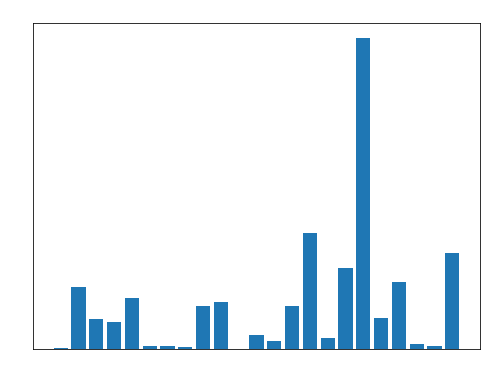

               cat chi_scores
0   Cabin_Deck_0.0   0.170003
1   Cabin_Deck_1.0     25.419
2   Cabin_Deck_2.0    12.4764
3   Cabin_Deck_3.0    10.9399
4   Cabin_Deck_4.0    21.1855
5   Cabin_Deck_5.0    1.31517
6   Cabin_Deck_6.0    1.21445
7   Cabin_Deck_7.0   0.607223
8   Cabin_Deck_8.0    17.6687
9     Embarked_0.0    19.4129
10    Embarked_1.0  0.0866758
11    Embarked_2.0    5.75272
12    Embarked_3.0    3.29368
13    No_Cabin_1.0    17.6687
14      Pclass_1.0    47.9465
15      Pclass_2.0     4.3794
16      Pclass_3.0    33.5921
17         Sex_0.0    128.392
18    bin_fare_0.0     12.881
19    bin_fare_1.0    27.7996
20    bin_fare_2.0    1.99696
21    bin_fare_3.0    1.20842
22    bin_fare_4.0    39.5446
selected: 
           columns   scores
0  Cabin_Deck_1.0   25.419
1  Cabin_Deck_4.0  21.1855
2  Cabin_Deck_8.0  17.6687
3    Embarked_0.0  19.4129
4    No_Cabin_1.0  17.6687
5      Pclass_1.0  47.9465
6      Pclass_3.0  33.5921
7         Sex_0.0  128.392
8    bin_fare_1.0  27.799

In [83]:
# cols
oh_no_cols = np.setdiff1d(oh_cols,['Sex_1.0','No_Cabin_0.0']) # no reason to keep binary
best_cols = selectKBest_and_plot(X_ohe,oh_no_cols,y,10,v=True)
# keep only the best out of the one-hotted, but retain numeric as well.
X_ohe_filt = X_ohe.drop(np.setdiff1d(oh_cols,best_cols.columns),axis=1)
# X_ohe_filt.drop('Sex_0.0',axis=1,inplace=True)
filt_score = cross_val_score_that_isnt_crap(RandomForestClassifier(n_estimators=400),X_ohe_filt,y)
results.append(('one_hot filtered by kbest',filt_score))
# rf =
# filt_score = roc_auc_score(y_cv,lr.predict(x_cv))
print("kbest from one-hot: ",filt_score)

In [84]:
pd.DataFrame([[X_ohe.shape,ohe_no_female.shape,X_ohe_filt.shape],[ohe_score,ohe_no_female_score,filt_score]],columns=['pure_one_hot','oh_no_female','filtered'],index=['shape','score'])


,pure_one_hot,oh_no_female,filtered
shape,"(712, 33)","(712, 32)","(712, 18)"
score,0.767038,0.770988,0.784342


In [85]:
# # what's the deal with chi2 in sklearn?
# from sklearn.feature_selection import chi2
# mini_sex = train[['Survived','Sex']].head(2)
# x = np.atleast_2d(mini_sex['Sex']).T
# y_sex = mini_sex['Survived']
# chi_stat,pval = chi2(x,y)
# chi_stat_rev,pval_rev = chi2(np.atleast_2d(1-mini_sex['Sex']).T,mini_sex['Survived'])
# print(chi_stat,pval,'\n',chi_stat_rev,pval_rev)

In [86]:
# from scipy.stats import chi2_contingency
# cross = pd.crosstab(mini_sex['Sex'],mini_sex['Survived'])
# chi2scipy,*a = chi2_contingency(cross)
# print(chi_stat,'\n',chi_stat_rev,'\n',chi_stat+chi_stat_rev,'\n',chi2scipy)

## different approach: automatic feature selection with recursive feature extraction with cross validation (RFECV)

In [87]:
num_col_to_scale = numeric_df.drop(['1','bin_title',],axis=1).columns
num_col_to_scale
# X.dtypes

Index(['Relative', 'age_title', 'age_naive_imp', 'age_imp', 'Fare', 'Parch',
       'SibSp', 'age_imp^2', 'age_imp Fare', 'age_imp Parch', 'age_imp SibSp',
       'Fare^2', 'Fare Parch', 'Fare SibSp', 'Parch^2', 'Parch SibSp',
       'SibSp^2'],
      dtype='object')

In [97]:
cat_columns = ['Pclass', 'Sex', 'Embarked', 'Title', 'No_Age',
               'No_Cabin', 'Cabin_Deck', 'bin_imp','bin_title','bin_fare']
oh,cols = one_hot_inplace(X,cat_columns)
scale = StandardScaler()
oh[num_col_to_scale] = scale.fit_transform(oh[num_col_to_scale])
oh.drop(['age_imp', 'Sex_0'],axis=1,inplace=True)
# oh.head()
rfe = RFECV(LogisticRegression(n_jobs=-1))
rfe.fit(oh,y)

RFECV(estimator=LogisticRegression(n_jobs=-1))

38
Index(['Relative', 'age_title', 'Fare', 'Parch', 'SibSp', 'age_imp^2',
       'age_imp Fare', 'age_imp Parch', 'age_imp SibSp', 'Parch SibSp',
       'SibSp^2', 'Pclass_2', 'Pclass_3', 'Sex_1', 'Embarked_0', 'Embarked_2',
       'Title_0', 'Title_1', 'Title_2', 'Title_5', 'Title_6', 'Title_9',
       'Title_10', 'Title_12', 'No_Cabin_0', 'No_Cabin_1', 'Cabin_Deck_1',
       'Cabin_Deck_3', 'Cabin_Deck_4', 'Cabin_Deck_6', 'Cabin_Deck_8',
       'bin_imp_0.0', 'bin_imp_1.0', 'bin_imp_3.0', 'bin_title_3.0',
       'bin_title_4.0', 'bin_fare_1.0', 'bin_fare_4.0'],
      dtype='object')


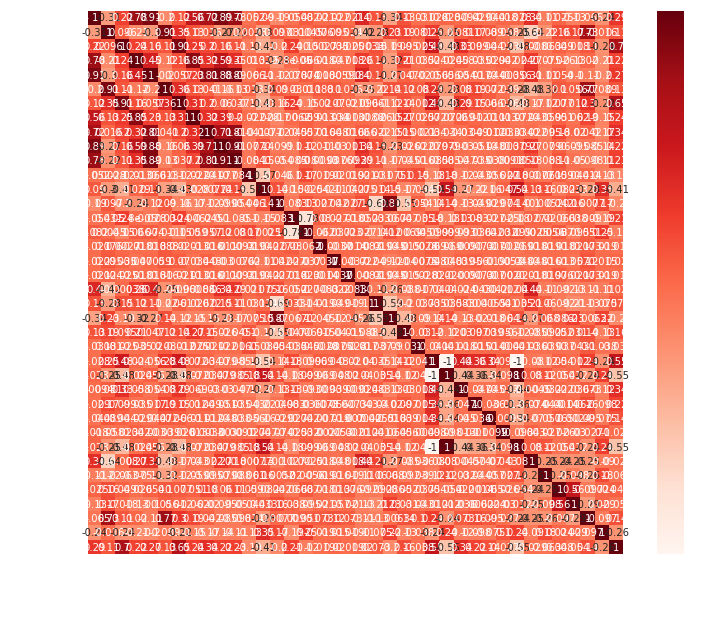

In [98]:
rfe_cols = oh.columns[rfe.get_support()]
print(rfe.n_features_)
print(rfe_cols)
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = oh[rfe_cols].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

looks like some cabin decks have a big enough change in distribution so that rfecv chooses them,
while others aren't.

In [99]:
        # drop columns that aren't important (seen from feature_importances_ of XGBoost.
        # self.drop_columns += ['SibSp_2', 'SibSp_5', 'SibSp_8',
        #                     'Embarked_-1', 'Cabin_Deck_F', 'Cabin_Deck_T',
        #                     'Pclass_1', 'Pclass_2', 'SibSp_0', 'SibSp_3', 'SibSp_4',
        #                      'Embarked_Q', 'Cabin_Deck_A',
        #                     'Cabin_Deck_B', 'Cabin_Deck_C', 'Cabin_Deck_D',
        #                     'Cabin_Deck_G']
print(oh.columns[~rfe.get_support()])
xbest = pd.DataFrame(rfe.transform(oh),columns=rfe_cols)
rfecv_score = cross_val_score_that_isnt_crap(RandomForestClassifier(n_estimators=400),xbest,y)
results.append(('rfecv score',rfecv_score))
print(rfecv_score)

Index(['age_naive_imp', 'Fare^2', 'Fare Parch', 'Fare SibSp', 'Parch^2',
       'Pclass_1', 'Embarked_1', 'Embarked_3', 'Title_3', 'Title_4', 'Title_7',
       'Title_8', 'Title_11', 'Title_13', 'Title_14', 'No_Age_0', 'No_Age_1',
       'Cabin_Deck_0', 'Cabin_Deck_2', 'Cabin_Deck_5', 'Cabin_Deck_7',
       'bin_imp_2.0', 'bin_imp_4.0', 'bin_title_0.0', 'bin_title_1.0',
       'bin_title_2.0', 'bin_fare_0.0', 'bin_fare_2.0', 'bin_fare_3.0'],
      dtype='object')
0.8020677215829224


results: similar, with much less work. cool.

,names,scores
0,naive_scaled,0.7751945287552277
1,filtered_kbest_cats,0.7638777185267059
2,one_hot w/ m&f,0.7670380151908514
3,one_hot without m|f,0.770988219777101
4,one_hot filtered by kbest,0.7843415531921313
5,rfecv score,0.7729155316773977


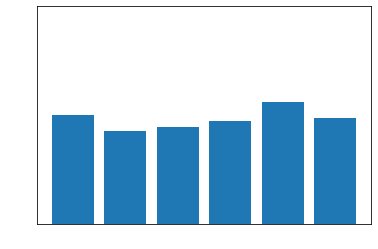

In [91]:
# graph results

names,heights = list(map(lambda x:x[0],results)),list(map(lambda x:x[1],results))
fig, ax = plt.subplots()
ax.bar(names,heights)
ax.set(ylim=[0.7, 0.85])
pd.DataFrame(np.array([names,heights]).T,columns=['names','scores'])

In [92]:
X

,Pclass,Sex,Embarked,Relative,Title,No_Age,No_Cabin,Cabin_Deck,age_title,age_naive_imp,...,age_imp^2,age_imp Fare,age_imp Parch,age_imp SibSp,Fare^2,Fare Parch,Fare SibSp,Parch^2,Parch SibSp,SibSp^2
0,1,0,2,0,6,0,1,8,22.000000,22.000000,...,484.0,3334.1000,0.0,0.0,22967.402500,0.0000,0.0000,0.0,0.0,0.0
1,2,1,2,0,9,0,1,8,33.000000,33.000000,...,1089.0,405.0750,0.0,0.0,150.675625,0.0000,0.0000,0.0,0.0,0.0
2,3,0,0,2,6,0,1,8,1.000000,1.000000,...,1.0,15.7417,2.0,0.0,247.801119,31.4834,0.0000,4.0,0.0,0.0
3,3,0,2,10,6,1,1,8,22.151786,29.514808,...,1024.0,2225.6000,64.0,256.0,4837.202500,139.1000,556.4000,4.0,16.0,64.0
4,2,1,2,0,9,0,1,8,70.000000,70.000000,...,4900.0,735.0000,0.0,0.0,110.250000,0.0000,0.0000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,3,0,2,0,6,0,1,8,21.000000,21.000000,...,441.0,160.6500,0.0,0.0,58.522500,0.0000,0.0000,0.0,0.0,0.0
708,1,1,2,0,9,1,1,8,32.024465,29.514808,...,1296.0,1116.0000,0.0,0.0,961.000000,0.0000,0.0000,0.0,0.0,0.0
709,3,1,2,2,9,0,1,8,41.000000,41.000000,...,1681.0,578.4403,0.0,82.0,199.044129,0.0000,28.2166,0.0,0.0,4.0
710,1,0,2,3,6,0,0,1,14.000000,14.000000,...,196.0,1680.0000,28.0,14.0,14400.000000,240.0000,120.0000,4.0,2.0,1.0


In [93]:


    # for i, (train_index, cv_index) in enumerate(kf.split(X)):
    #     best_clf.fit(X.iloc[train_index],y.iloc[train_index])
    #     pred = random_search.best_estimator_.predict(X.iloc[cv_index])
    #     # print(confusion_matrix(y.iloc[cv_index],pred))
    #     scores_cv_f1[i] = f1_score(y.iloc[cv_index],pred)
    #     # print(scores_cv_f1[i])
    # print('f1 (self-made test): ',scores_cv_f1.mean())